# Libraries 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image, ImageDraw, ImageOps
from collections import Counter
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    RandomApply,
    InterpolationMode,
    RandomCrop,
    RandomResizedCrop,
    CenterCrop
)
import torchvision
import torch
import cv2
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import SimpleITK as sitk
from pathlib import Path
from sklearn.cluster import KMeans
import nibabel as nib
import imageio
import pytesseract
from pytesseract import Output
import zipfile
import h5py

# Preprocessing

In [ ]:
def get_text_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=Output.DICT)

    mask = np.zeros_like(gray, dtype=np.uint8)
    n_boxes = len(d['level'])

    for i in range(n_boxes):
        (x, y, w, h, text) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i], d['text'][i])
        if text.strip() != "":
            cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    return mask

# === 1. CLAHE Enhancer ===
def apply_clahe_to_bgr(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

# === 2. Colored Annotation Mask via HSV + KMeans ===
def get_annotation_mask_kmeans_clahe(image, k=3, sat_thresh=40, min_area=20):
    image_clahe = apply_clahe_to_bgr(image)
    hsv = cv2.cvtColor(image_clahe, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    mask_color = s > sat_thresh
    pixels = hsv[mask_color]

    if len(pixels) < k:
        return np.zeros(image.shape[:2], dtype=np.uint8)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_

    mask_result = np.zeros(hsv.shape[:2], dtype=np.uint8)
    for i, center in enumerate(centers):
        h_c, s_c, v_c = center
        if s_c > sat_thresh and v_c > 20:
            match_mask = (labels == i)
            color_pixels_idx = np.where(mask_color)
            mask_result[color_pixels_idx[0][match_mask], color_pixels_idx[1][match_mask]] = 255

    num_labels, labels_img, stats, _ = cv2.connectedComponentsWithStats(mask_result, connectivity=8)
    cleaned_mask = np.zeros_like(mask_result)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned_mask[labels_img == i] = 255

    return cleaned_mask

# === 3. Grayscale Annotation Mask via Canny + Contour Filtering ===
def get_grayscale_annotation_mask(image, min_area=30, max_area=2000):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    edges = cv2.Canny(enhanced, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            cv2.drawContours(mask, [cnt], -1, 255, -1)
    return mask

# === 4. Combine Masks ===
def get_combined_annotation_mask(image, k=3, sat_thresh=40, color_min_area=20, gray_min_area=30, gray_max_area=2000):
    color_mask = get_annotation_mask_kmeans_clahe(image, k=k, sat_thresh=sat_thresh, min_area=color_min_area)
    gray_mask = get_grayscale_annotation_mask(image, min_area=gray_min_area, max_area=gray_max_area)
    text_mask = get_text_mask(image)

    combined_mask = cv2.bitwise_or(color_mask, gray_mask)
    combined_mask = cv2.bitwise_or(combined_mask, text_mask)
    return combined_mask

# === 5. Inpainting ===
def clean_and_inpaint(image, mask, radius=3):
    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)
    result = cv2.inpaint(image, mask_clean, inpaintRadius=radius, flags=cv2.INPAINT_NS)
    return result, mask_clean

# === Updated 6. Deannotation with Saving ===
def deannotate_image(image_path, output_path=None, show=False):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"[WARN] Could not read image: {image_path}")
        return

    combined_mask = get_combined_annotation_mask(image)
    inpainted, _ = clean_and_inpaint(image, combined_mask)

    # Save output if path is provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(str(output_path), inpainted)

    # Show preview (optional)
    if show:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Inpainted")
        plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# === Batch Processor ===
def batch_deannotate_images(input_root, output_root):
    image_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    input_root = Path(input_root)
    output_root = Path(output_root)

    image_paths = [p for p in input_root.rglob("*") if p.suffix.lower() in image_extensions]

    print(f"[INFO] Found {len(image_paths)} images to process.")

    for img_path in image_paths:
        relative_path = img_path.relative_to(input_root)
        output_path = output_root / relative_path.with_suffix(".png")  # save all as .png
        deannotate_image(img_path, output_path=output_path, show=False)

    print(f"[DONE] Inpainted images saved to {output_root}")

## example usage:
# batch_deannotate_images(
#     input_root="../US Datasets/AUL",
#     output_root="../US Datasets/AUL/images_inpainted"
# )

## Below is a single dataset preprocessing example in case the batch annotation didn't work well

# AUL dataset

In [40]:
images_path_parent = "../US Datasets/AUL/"
images_path_sub = ['Benign', 'Malignant', 'Normal']

shape_counter = Counter()
total_images = 0

for sub_folder in images_path_sub:
    folder_path = os.path.join(images_path_parent, sub_folder)
    image_files = os.listdir(folder_path)
    print(f"{sub_folder} Subfolder has {len(image_files)} images")
    total_images += len(image_files)
    
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                shape = img.size  # (width, height)
                shape_counter[shape] += 1
        except Exception as e:
            print(f"Failed to open {img_file} in {sub_folder}: {e}")

print(f"\nTotal number of images: {total_images}")
print("\nUnique image shapes and their counts:")
for shape, count in shape_counter.items():
    print(f"Shape {shape}: {count} images")


Benign Subfolder has 200 images
Malignant Subfolder has 435 images
Normal Subfolder has 100 images

Total number of images: 735

Unique image shapes and their counts:
Shape (1024, 768): 352 images
Shape (720, 576): 232 images
Shape (602, 489): 15 images
Shape (768, 576): 46 images
Shape (640, 480): 21 images
Shape (800, 600): 38 images
Shape (819, 604): 2 images
Shape (569, 419): 2 images
Shape (1260, 910): 6 images
Shape (1388, 806): 3 images
Shape (550, 407): 3 images
Shape (623, 514): 4 images
Shape (643, 514): 1 images
Shape (894, 749): 1 images
Shape (440, 341): 2 images
Shape (1089, 817): 1 images
Shape (600, 450): 1 images
Shape (800, 608): 1 images
Shape (1038, 808): 2 images
Shape (507, 407): 1 images
Shape (819, 625): 1 images


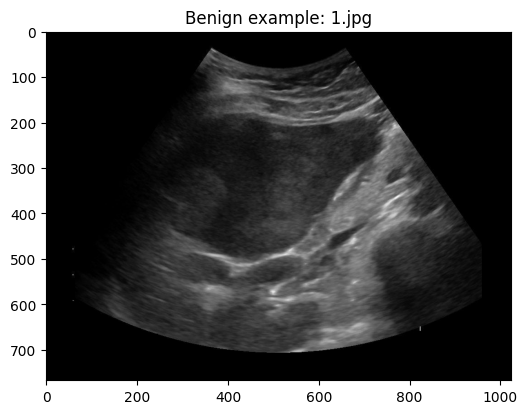

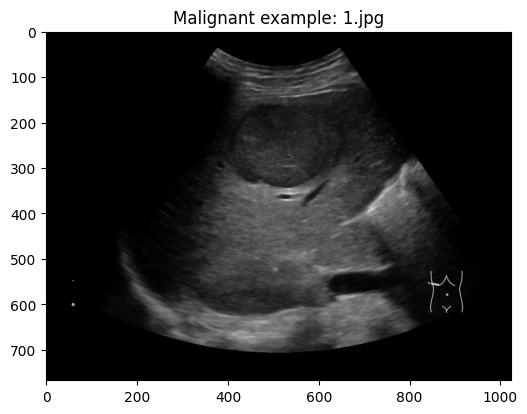

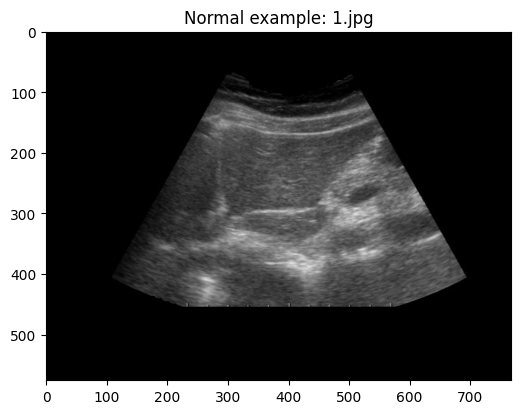

In [41]:
images_path_parent = "../US Datasets/AUL/"
images_path_sub = ['Benign', 'Malignant', 'Normal'] # 24 in Malignant
valid_exts = ('.jpeg', '.jpg', '.png')

def find_first_image(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(valid_exts):
                return os.path.join(root, file)
    return None

for sub_folder in images_path_sub:
    folder_path = os.path.join(images_path_parent, sub_folder)
    img_path = find_first_image(folder_path)

    if img_path:
        with Image.open(img_path) as img:
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap='gray')
            plt.axis('on')
            plt.title(f"{sub_folder} example: {os.path.basename(img_path)}")
            plt.show()
    else:
        print(f"No valid image found in {sub_folder}")


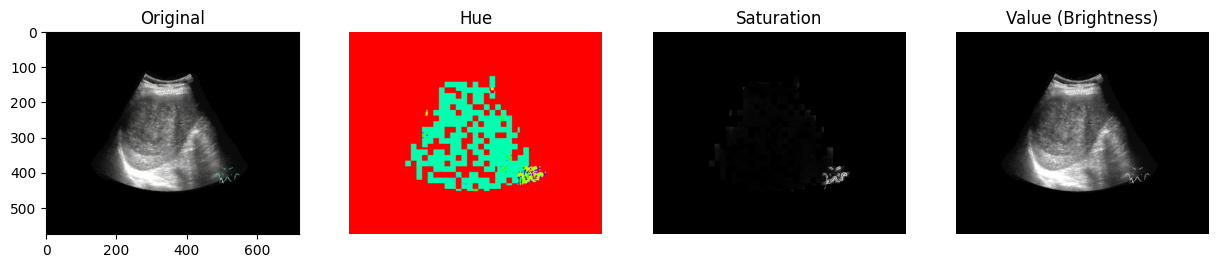

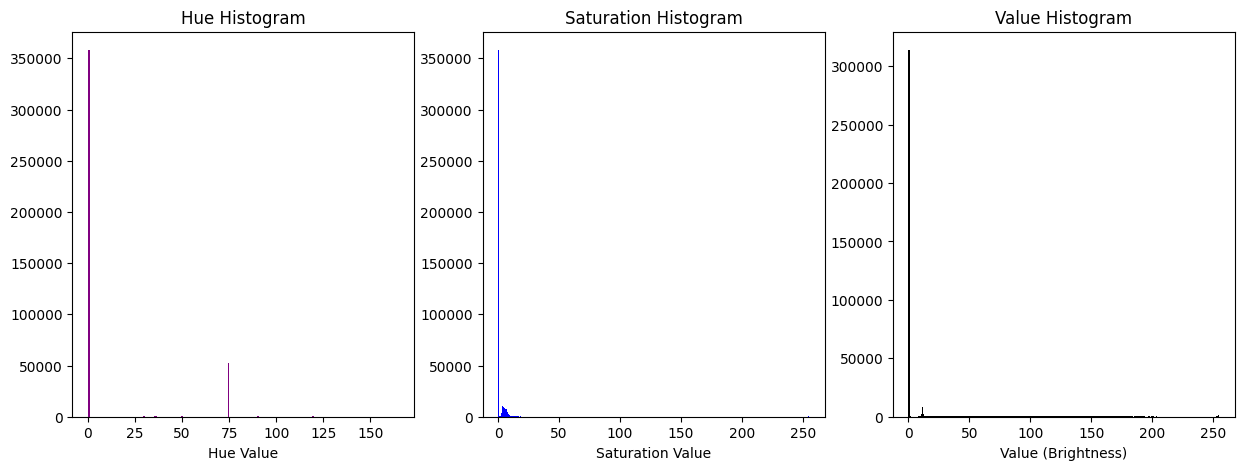

In [42]:
image = cv2.imread('../US Datasets/AUL/Malignant/24.jpg')

hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

H, S, V = cv2.split(hsv_img)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(image)
plt.axis('on')

plt.subplot(1, 4, 2)
plt.title('Hue')
plt.imshow(H, cmap='hsv')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Saturation')
plt.imshow(S, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Value (Brightness)')
plt.imshow(V, cmap='gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Hue Histogram')
plt.hist(H.ravel(), bins=180, color='purple')
plt.xlabel('Hue Value')

plt.subplot(1, 3, 2)
plt.title('Saturation Histogram')
plt.hist(S.ravel(), bins=256, color='blue')
plt.xlabel('Saturation Value')

plt.subplot(1, 3, 3)
plt.title('Value Histogram')
plt.hist(V.ravel(), bins=256, color='black')
plt.xlabel('Value (Brightness)')

plt.show()


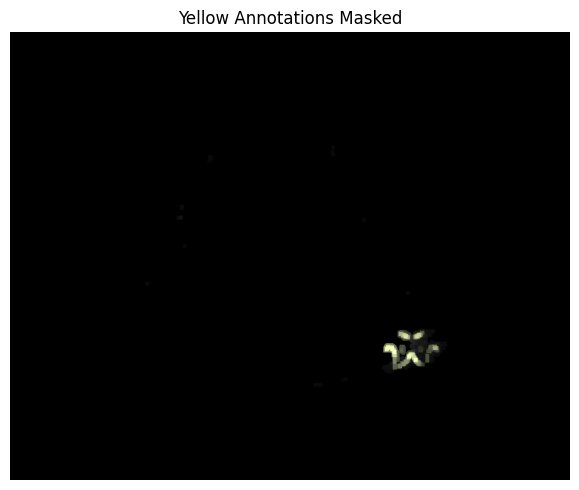

In [43]:
image = cv2.imread('../US Datasets/AUL/Malignant/24.jpg')

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_yellow = np.array([10, 50, 0])
upper_yellow = np.array([130, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

yellow_result = cv2.bitwise_and(image, image, mask=yellow_mask)

yellow_result_rgb = cv2.cvtColor(yellow_result, cv2.COLOR_BGR2RGB)

kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(yellow_result_rgb, kernel, iterations=1)

image_pil = Image.fromarray(dilated_mask)
image_pil.save("24_mask.png")

plt.figure(figsize=(10, 5))
plt.imshow(dilated_mask)
plt.title('Yellow Annotations Masked')
plt.axis('off')
plt.tight_layout()
plt.show()

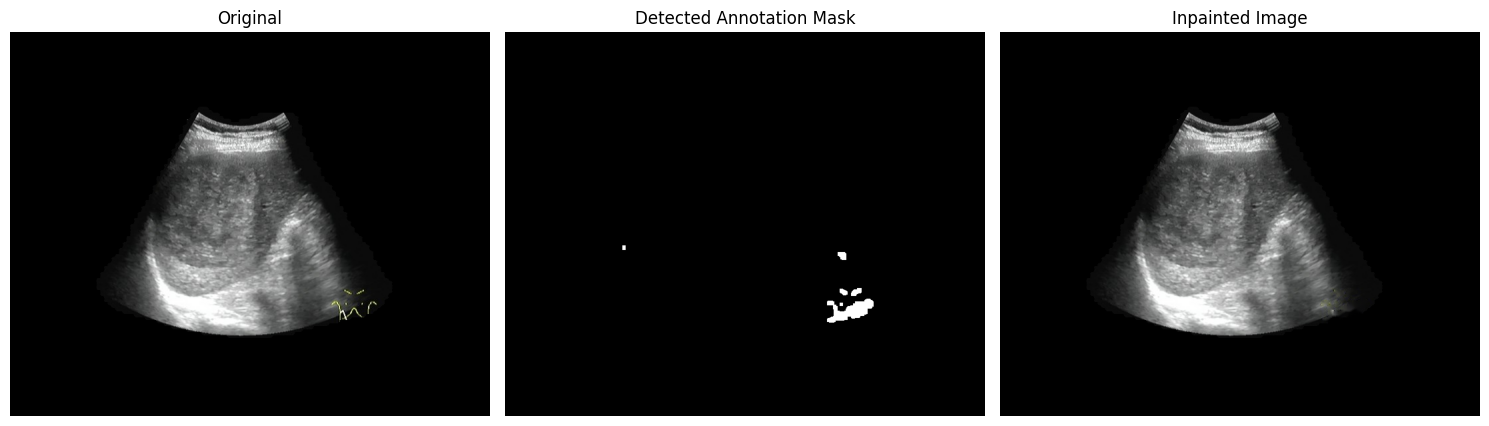

In [ ]:
def get_grayscale_annotation_mask(image, min_area=30, max_area=2000):
    # Enhance image with CLAHE for better edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Edge detection
    edges = cv2.Canny(enhanced, 50, 150)

    # Dilate to close gaps in symbols
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Find contours and filter by area
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            cv2.drawContours(mask, [cnt], -1, 255, -1)

    return mask

def apply_clahe_to_bgr(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_img

def get_annotation_mask_kmeans_clahe(image, k=3, sat_thresh=40, min_area=20):
    # Step 1: Enhance contrast using CLAHE
    image_clahe = apply_clahe_to_bgr(image)

    # Step 2: Convert to HSV
    hsv = cv2.cvtColor(image_clahe, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Step 3: Filter only saturated pixels (likely to be colored annotations)
    mask_color = s > sat_thresh
    pixels = hsv[mask_color]

    if len(pixels) < k:
        return np.zeros(image.shape[:2], dtype=np.uint8)  # No color-rich pixels

    # Step 4: K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_

    mask_result = np.zeros(hsv.shape[:2], dtype=np.uint8)

    for i, center in enumerate(centers):
        h_c, s_c, v_c = center
        if s_c > sat_thresh and v_c > 20:
            match_mask = (labels == i)
            color_pixels_idx = np.where(mask_color)
            mask_result[color_pixels_idx[0][match_mask], color_pixels_idx[1][match_mask]] = 255

    # Step 5: Clean small artifacts
    num_labels, labels_img, stats, _ = cv2.connectedComponentsWithStats(mask_result, connectivity=8)
    cleaned_mask = np.zeros_like(mask_result)
    for i in range(1, num_labels):  # skip background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned_mask[labels_img == i] = 255

    return cleaned_mask

def clean_and_inpaint(image, mask, radius=3):
    kernel = np.ones((5, 5), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)
    result = cv2.inpaint(image, mask_clean, inpaintRadius=radius, flags=cv2.INPAINT_TELEA)
    return result, mask_clean


def demo_kmeans_deannotation(image_path, k=3):
    image = cv2.imread(image_path)
    mask = get_annotation_mask_kmeans_clahe(image, k=k)
    result, cleaned_mask = clean_and_inpaint(image, mask)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Detected Annotation Mask")
    plt.imshow(cleaned_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

demo_kmeans_deannotation('../US Datasets/AUL/Malignant/24.jpg', k=3)

# image = cv2.imread("../US Datasets/AUL/Malignant/24.jpg")
# mask = get_grayscale_annotation_mask(image)
# result, cleaned_mask = clean_and_inpaint(image, mask)

# # Visualize
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.title("Original")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title("Grayscale Annotation Mask")
# plt.imshow(cleaned_mask, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("Inpainted Image")
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.tight_layout()
# plt.show()


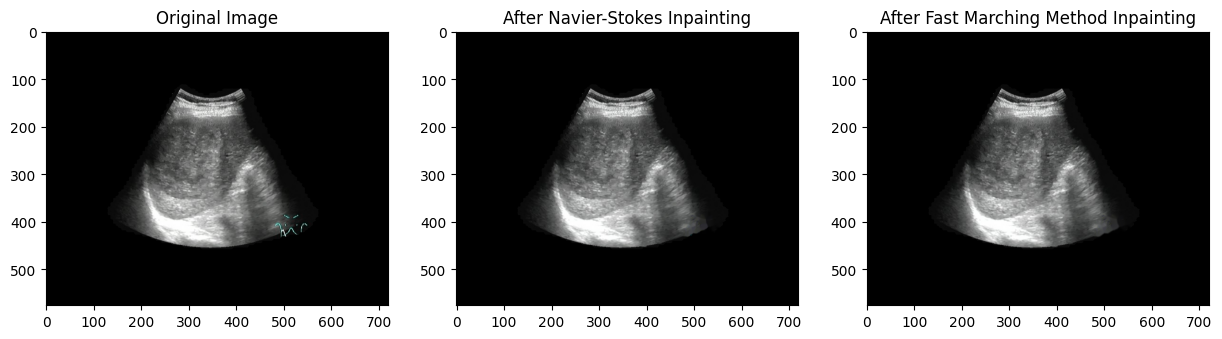

In [44]:
image = cv2.imread('../US Datasets/AUL/Malignant/24.jpg')

mask = cv2.imread('24_mask.png', cv2.IMREAD_GRAYSCALE)

# Optional: Ensure binary mask is clean (0 or 255)
# mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

# Apply Navier-Stokes inpainting (cv2.INPAINT_NS) or Fast Marching Method (cv2.INPAINT_TELEA)
inpainted_ns = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)
inpainted_telea = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

inpainted_ns_rgb = cv2.cvtColor(inpainted_ns, cv2.COLOR_BGR2RGB)
inpainted_telea_rgb = cv2.cvtColor(inpainted_telea, cv2.COLOR_BGR2RGB)

image_pil = Image.fromarray(inpainted_ns_rgb)
image_pil.save("24_inpainted_ns.png")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('on')

plt.subplot(1, 3, 2)
plt.title('After Navier-Stokes Inpainting')
plt.imshow(inpainted_ns_rgb)
plt.axis('on')

plt.subplot(1, 3, 3)
plt.title('After Fast Marching Method Inpainting')
plt.imshow(inpainted_telea_rgb)
plt.axis('on')

plt.show()

## Apply Navier-Stokes Inpainting to all AUL dataset

In [45]:
%%time

images_path_parent = "../US Datasets/AUL/"
images_path_sub = ['Benign', 'Malignant', 'Normal']
output_path_parent = "../US Datasets/AUL/Images Dataset Mask/"
os.makedirs(output_path_parent, exist_ok=True)

shape_counter = Counter()
total_images = 0

for sub_folder in images_path_sub:
    folder_path = os.path.join(images_path_parent, sub_folder)

    # Recursively find images
    for root, _, files in os.walk(folder_path):
        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, img_file)

                # Compute relative path and matching output folder
                rel_path = os.path.relpath(root, start=images_path_parent)
                output_folder = os.path.join(output_path_parent, rel_path)
                os.makedirs(output_folder, exist_ok=True)

                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Failed to read image: {img_path}")
                        continue
                        
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    lower_yellow = np.array([10, 50, 0])
                    upper_yellow = np.array([130, 255, 255])
                    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
                    
                    yellow_result = cv2.bitwise_and(img, img, mask=yellow_mask)
                    
                    yellow_result_rgb = cv2.cvtColor(yellow_result, cv2.COLOR_BGR2RGB)
                    
                    kernel = np.ones((5, 5), np.uint8)
                    dilated_mask = cv2.dilate(yellow_result_rgb, kernel, iterations=1)

                    image_pil = Image.fromarray(cv2.cvtColor(dilated_mask, cv2.COLOR_BGR2RGB))
                    base_name, _ = os.path.splitext(img_file)
                    new_filename = f"{base_name}_mask.png"
                    save_path = os.path.join(output_folder, new_filename)
                    image_pil.save(save_path)

                    total_images += 1

                except Exception as e:
                    print(f"Failed to process {img_file} in {root}: {e}")

print(f"\n✅ Total images masked and saved: {total_images}")



✅ Total images masked and saved: 735
CPU times: total: 13.1 s
Wall time: 6.28 s


In [46]:
%%time

images_path_parent = "../US Datasets/AUL/"
masks_path_parent = "../US Datasets/AUL/Images Dataset Mask/" 
output_path_parent = "../US Datasets/AUL/Images Dataset Inpainted/"
images_path_sub = ['Benign', 'Malignant', 'Normal']

os.makedirs(output_path_parent, exist_ok=True)
shape_counter = Counter()
total_images = 0

for sub_folder in images_path_sub:
    folder_path = os.path.join(images_path_parent, sub_folder)

    for root, _, files in os.walk(folder_path):
        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, img_file)

                rel_path = os.path.relpath(root, start=images_path_parent)

                base_name, ext = os.path.splitext(img_file)
                mask_filename = f"{base_name}_mask.png"
                
                mask_path = os.path.join(masks_path_parent, rel_path, mask_filename)
                output_folder = os.path.join(output_path_parent, rel_path)
                os.makedirs(output_folder, exist_ok=True)

                try:
                    image = cv2.imread(img_path)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if image is None or mask is None:
                        print(f"Failed to read {img_path} or {mask_path}")
                        continue

                    inpainted_ns = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)
                    inpainted_ns_rgb = cv2.cvtColor(inpainted_ns, cv2.COLOR_BGR2RGB)

                    image_pil = Image.fromarray(inpainted_ns_rgb)
                    base_name, _ = os.path.splitext(img_file)
                    new_filename = f"{base_name}_inpainted_ns.png"
                    save_path = os.path.join(output_folder, new_filename)
                    image_pil.save(save_path)

                    total_images += 1

                except Exception as e:
                    print(f"❌ Error processing {img_path}: {e}")

print(f"\n✅ Total images inpainted and saved: {total_images}")



✅ Total images inpainted and saved: 735
CPU times: total: 25.1 s
Wall time: 22 s
